In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

In [3]:
from time import time

In [4]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [5]:
def cuda_wrapper(torch_obj):
    if USE_CUDA:
        return torch_obj.cuda()
    else:
        return torch_obj

In [6]:
class ModelFullyConnected(nn.Module):

    def __init__(self, num_hidden=1, hidden_size=32, dropout_rate=0.5):
        super(ModelFullyConnected, self).__init__()
        assert num_hidden > 0
        self.input_size = (28, 28)
        self.output_size = 10
        self.num_hidden = num_hidden
        self.dropout_rate = dropout_rate
        self.input_layer = nn.Linear(self.input_size[0] * self.input_size[1], hidden_size)
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, self.output_size)

    def forward(self, inputs):
        x = inputs.view(-1, self.input_size[0] * self.input_size[1])
        x = F.dropout(F.relu(self.input_layer(x)), p=self.dropout_rate)
        for layer in self.hidden_layers:
            x = F.dropout(F.relu(layer(x)), p=self.dropout_rate)
        x = self.output_layer(x)
        return F.log_softmax(x, dim=1)

In [7]:
class ModelConvolutional(nn.Module):

    def __init__(self, num_hidden=1, fc_hidden_size=32, dropout_rate=0.5, num_filters=16, filter_size=3):
        super(ModelConvolutional, self).__init__()
        assert num_hidden > 0
        self.input_size = (28, 28)
        self.output_size = 10
        self.num_hidden = num_hidden
        self.num_filters = num_filters
        self.dropout_rate = dropout_rate
        self.input_layer = nn.Conv2d(1, num_filters, filter_size)
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden):
            self.hidden_layers.append(nn.Conv2d(num_filters, num_filters, filter_size))
        self.size_after_convs = (
            self.input_size[0] - (filter_size - 1) * (num_hidden + 1), 
            self.input_size[1] - (filter_size - 1) * (num_hidden + 1)
        )
        self.fc_layer = nn.Linear(self.size_after_convs[0] * self.size_after_convs[1] * num_filters, fc_hidden_size)
        self.output_layer = nn.Linear(fc_hidden_size, self.output_size)

    def forward(self, inputs):
        x = inputs.view(-1, 1, self.input_size[0], self.input_size[1])
        x = F.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = x.view(-1, self.size_after_convs[0] * self.size_after_convs[1] * self.num_filters)
        #print(x.size())
        x = F.dropout(F.relu(self.fc_layer(x)), p=self.dropout_rate)
        #print(x.size())
        x = self.output_layer(x)
        #print(x.size())
        return F.log_softmax(x, dim=1)

In [8]:
class AdaSGD():
    
    def __init__(self, params, init_base_lr=0, meta_lr=1e-3, meta_betas=(0.9, 0.999), meta_eps=1e-8, 
                 separate_lrs=False, accumulate_grads=True):
        self.params = list(params)
        self.separate_lrs = separate_lrs
        self.accumulate_grads = accumulate_grads
        if separate_lrs:
            self.base_lrs = []
            self.grads = []
            for _ in self.params:
                self.base_lrs.append(nn.Parameter(torch.Tensor([init_base_lr])))
                self.base_lrs[-1].grad = torch.zeros_like(self.base_lrs[-1])
                self.grads.append(0)
            self.meta_opt = optim.Adam(self.base_lrs, lr=meta_lr, betas=meta_betas, eps=meta_eps)
        else:
            self.base_lr = nn.Parameter(torch.Tensor([init_base_lr]))
            self.base_lr.grad = torch.zeros_like(self.base_lr)
            self.meta_opt = optim.Adam([self.base_lr], lr=meta_lr, betas=meta_betas, eps=meta_eps)
            self.flat_grads = 0
        
    def step(self):
        if self.separate_lrs:
            for i, param in enumerate(self.params):
                if self.accumulate_grads:
                    self.grads[i] += param.grad.data.view(-1)
                else:
                    self.grads[i] = param.grad.data.view(-1)
                param.data -= self.base_lrs[i].data[0] * param.grad.data
        else:
            grads = []
            for param in self.params:
                grads.append(param.grad.data.view(-1))
            if self.accumulate_grads:
                self.flat_grads += torch.cat(grads)
            else:
                self.flat_grads = torch.cat(grads)
            for param in self.params:
                param.data -= self.base_lr.data[0] * param.grad.data 

    def meta_step(self):
        if self.separate_lrs:
            self.meta_opt.zero_grad()
            for i, param in enumerate(self.params):
                self.base_lrs[i].grad.data = torch.clamp(
                    torch.Tensor([-torch.sum(self.grads[i] * param.grad.data.view(-1))]), -1, 1
                )
            self.meta_opt.step()
            self.grads = [0] * len(self.params)
        else:
            grads = []
            for param in self.params:
                grads.append(param.grad.data.view(-1))
            flat_grads_new = torch.cat(grads)
            self.meta_opt.zero_grad()
            self.base_lr.grad.data = torch.clamp(
                torch.Tensor([-torch.sum(self.flat_grads * flat_grads_new)]), -1, 1
            )
            self.meta_opt.step()
            self.flat_grads = 0

In [9]:
batch_size = 32
test_batch_size = 32
max_epoch = 20
do_validation = False

In [10]:
kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [11]:
losses = {}
test_losses = {}
times = {}
learning_rates = {}

In [ ]:
Model = ModelFullyConnected
model_kwargs = {
    'num_hidden': 2, 
    'hidden_size': 256, 
    'dropout_rate': 0.8
}
model_name = '_'.join(['fc'] + [key + '=' + str(val) for key, val in model_kwargs.items()])
print(model_name)

In [13]:
Model = ModelConvolutional
model_kwargs = {
    'num_hidden': 2, 
    'fc_hidden_size': 256, 
    'dropout_rate': 0.5,
    'num_filters': 16,
    'filter_size': 3
}
model_name = '_'.join(['conv'] + [key + '=' + str(val) for key, val in model_kwargs.items()])
print(model_name)

conv_num_hidden=2_fc_hidden_size=256_dropout_rate=0.5_num_filters=16_filter_size=3


In [14]:
losses[model_name] = {}
test_losses[model_name] = {}
times[model_name] = {}
learning_rates[model_name] = {}

In [19]:
torch.manual_seed(123)

#meta_opt_names = []

run_count = 3

meta_lr = 1e-3
sep_lrs = True

for truncated_bptt_step in [10, 100]:
    opt_name = 'AdaSGD' + '_bptt_steps=' + str(truncated_bptt_step) + '_meta_lr=' + str(meta_lr) + \
    '_sep_lrs=' + str(sep_lrs)
    print(opt_name)
    meta_opt_names.append(opt_name)
    
    losses[model_name][opt_name] = []
    test_losses[model_name][opt_name] = []
    times[model_name][opt_name] = []
    learning_rates[model_name][opt_name] = []
    
    for run in range(run_count):
        losses[model_name][opt_name].append([])
        test_losses[model_name][opt_name].append([])
        times[model_name][opt_name].append([])
        learning_rates[model_name][opt_name].append([])
        
        model = cuda_wrapper(Model(**model_kwargs))
        opt = AdaSGD(model.parameters(), meta_lr=meta_lr, separate_lrs=sep_lrs)

        av_loss = 0
        av_test_loss = 0
        alpha = 0.999
        global_step = 0

        start_time = time()

        for epoch in range(max_epoch):
            epoch_start_time = time()
            for X, y in train_loader:
                X, y = Variable(cuda_wrapper(X)), Variable(cuda_wrapper(y))
                prob = model(X)
                loss = F.nll_loss(prob, y)
                model.zero_grad()
                do_meta_step = ((global_step + 1) % truncated_bptt_step == 0)
                if do_meta_step:
                    loss.backward(retain_graph=True)
                else:
                    loss.backward()
                opt.step()
                
                av_loss = alpha * av_loss + (1 - alpha) * loss.data[0]
                losses[model_name][opt_name][run].append(loss.data[0])
                
                if do_meta_step:
                    prob = model(X)
                    loss = F.nll_loss(prob, y)
                    model.zero_grad()
                    loss.backward()
                    opt.meta_step()
                    
                #learning_rates[model_name][opt_name][run].append(opt.base_lr.data[0])
                times[model_name][opt_name][run].append(time() - start_time)
                
                global_step += 1
                
            if do_validation:
                for X, y in test_loader:
                    X, y = Variable(cuda_wrapper(X)), Variable(cuda_wrapper(y))
                    prob = model(X)
                    loss = F.nll_loss(prob, y)
                
                    av_test_loss = alpha * av_test_loss + (1 - alpha) * loss.data[0]
                    test_losses[model_name][opt_name][run].append(test_loss.data[0])

            print('epoch {} took {:.1f}s; av_loss = {:.3f}; av_test_loss = {:.3f}'.format(
                epoch+1, time() - epoch_start_time, av_loss, av_test_loss
            ))
            if sep_lrs:
                print('learning rates:', end=' ')
                for lr in opt.base_lrs:
                    print('{:.3f}'.format(lr.data[0]), end=' ')
                print()
            else:
                print('learning rate: {:.3f}'.format(opt.base_lr.data[0]))
        
        print()
        
    losses[model_name][opt_name] = np.array(losses[model_name][opt_name])
    test_losses[model_name][opt_name] = np.array(test_losses[model_name][opt_name])
    times[model_name][opt_name] = np.array(times[model_name][opt_name])
    #learning_rates[model_name][opt_name] = np.array(learning_rates[model_name][opt_name])


AdaSGD_bptt_steps=10_meta_lr=0.001_sep_lrs=True
epoch 1 took 8.1s; av_loss = 0.203; av_test_loss = 0.000
learning rates: 0.020 0.023 0.025 0.019 0.020 0.019 0.049 0.016 0.005 0.006 
epoch 2 took 8.5s; av_loss = 0.107; av_test_loss = 0.000
learning rates: 0.019 0.027 0.023 0.020 0.006 0.019 0.072 0.016 0.011 0.005 
epoch 3 took 8.3s; av_loss = 0.063; av_test_loss = 0.000
learning rates: 0.018 0.028 0.020 0.020 -0.008 0.018 0.081 0.016 0.011 0.005 
epoch 4 took 7.4s; av_loss = 0.070; av_test_loss = 0.000
learning rates: 0.011 0.013 0.024 0.010 0.034 0.047 0.078 0.014 0.012 0.003 
epoch 5 took 8.0s; av_loss = 0.038; av_test_loss = 0.000
learning rates: 0.012 0.014 0.024 0.010 0.030 0.047 0.081 0.014 0.007 0.002 
epoch 6 took 7.5s; av_loss = 0.024; av_test_loss = 0.000
learning rates: 0.012 0.014 0.023 0.010 0.029 0.047 0.086 0.014 0.009 0.002 
epoch 7 took 7.3s; av_loss = 0.018; av_test_loss = 0.000
learning rates: 0.012 0.014 0.022 0.009 0.027 0.047 0.088 0.014 0.007 0.002 
epoch 8 took 

epoch 1 took 7.4s; av_loss = 0.393; av_test_loss = 0.000
learning rates: 0.013 0.009 0.014 0.006 0.014 0.008 0.013 0.010 0.011 0.004 
epoch 2 took 7.2s; av_loss = 0.164; av_test_loss = 0.000
learning rates: 0.017 0.011 0.017 0.008 0.017 0.009 0.014 0.012 0.016 0.006 
epoch 3 took 7.9s; av_loss = 0.095; av_test_loss = 0.000
learning rates: 0.017 0.012 0.017 0.008 0.018 0.010 0.017 0.013 0.022 0.006 
epoch 4 took 7.7s; av_loss = 0.071; av_test_loss = 0.000
learning rates: 0.017 0.012 0.017 0.009 0.018 0.010 0.018 0.013 0.024 0.006 
epoch 5 took 8.5s; av_loss = 0.054; av_test_loss = 0.000
learning rates: 0.017 0.012 0.016 0.009 0.016 0.010 0.020 0.013 0.026 0.006 
epoch 6 took 8.1s; av_loss = 0.042; av_test_loss = 0.000
learning rates: 0.016 0.012 0.015 0.009 0.016 0.010 0.019 0.013 0.026 0.006 
epoch 7 took 8.3s; av_loss = 0.030; av_test_loss = 0.000
learning rates: 0.016 0.012 0.015 0.009 0.015 0.010 0.018 0.013 0.025 0.006 
epoch 8 took 7.9s; av_loss = 0.022; av_test_loss = 0.000
learn

In [21]:
torch.manual_seed(123)

opt_names = []

run_count = 3

for lr in [0.01, 0.02, 0.05, 0.1]:
    opt_name = 'SGD' + '_lr=' + str(lr)
    print(opt_name)
    opt_names.append(opt_name)
    
    losses[model_name][opt_name] = []
    test_losses[model_name][opt_name] = []
    times[model_name][opt_name] = []
    learning_rates[model_name][opt_name] = []
    
    for run in range(run_count):
        losses[model_name][opt_name].append([])
        test_losses[model_name][opt_name].append([])
        times[model_name][opt_name].append([])
        learning_rates[model_name][opt_name].append([])
        
        model = cuda_wrapper(Model(**model_kwargs))
        opt = optim.SGD(model.parameters(), lr=lr)

        av_loss = 0
        av_test_loss = 0
        alpha = 0.999
        global_step = 0

        start_time = time()

        for epoch in range(max_epoch):
            epoch_start_time = time()
            for X, y in train_loader:
                X, y = Variable(cuda_wrapper(X)), Variable(cuda_wrapper(y))
                prob = model(X)
                loss = F.nll_loss(prob, y)
                model.zero_grad()
                loss.backward()
                opt.step()
                
                av_loss = alpha * av_loss + (1 - alpha) * loss.data[0]
                losses[model_name][opt_name][run].append(loss.data[0])
                
                learning_rates[model_name][opt_name][run].append(lr)
                times[model_name][opt_name][run].append(time() - start_time)
                
                global_step += 1
                
            if do_validation:
                for X, y in test_loader:
                    X, y = Variable(cuda_wrapper(X)), Variable(cuda_wrapper(y))
                    prob = model(X)
                    loss = F.nll_loss(prob, y)
                
                    av_test_loss = alpha * av_test_loss + (1 - alpha) * loss.data[0]
                    test_losses[model_name][opt_name][run].append(test_loss.data[0])

            print('epoch {} took {:.1f}s; av_loss = {:.3f}; av_test_loss = {:.3f}; lr = {:.4f}'.format(
                epoch+1, time() - epoch_start_time, av_loss, av_test_loss, lr
            ))
        
        print()
        
    losses[model_name][opt_name] = np.array(losses[model_name][opt_name])
    test_losses[model_name][opt_name] = np.array(test_losses[model_name][opt_name])
    times[model_name][opt_name] = np.array(times[model_name][opt_name])
    learning_rates[model_name][opt_name] = np.array(learning_rates[model_name][opt_name])


SGD_lr=0.01
epoch 1 took 7.7s; av_loss = 0.186; av_test_loss = 0.000; lr = 0.0100
epoch 2 took 7.9s; av_loss = 0.118; av_test_loss = 0.000; lr = 0.0100
epoch 3 took 7.1s; av_loss = 0.082; av_test_loss = 0.000; lr = 0.0100
epoch 4 took 7.4s; av_loss = 0.060; av_test_loss = 0.000; lr = 0.0100
epoch 5 took 7.7s; av_loss = 0.046; av_test_loss = 0.000; lr = 0.0100
epoch 6 took 7.6s; av_loss = 0.037; av_test_loss = 0.000; lr = 0.0100
epoch 7 took 7.2s; av_loss = 0.029; av_test_loss = 0.000; lr = 0.0100
epoch 8 took 7.3s; av_loss = 0.023; av_test_loss = 0.000; lr = 0.0100
epoch 9 took 7.5s; av_loss = 0.019; av_test_loss = 0.000; lr = 0.0100
epoch 10 took 7.6s; av_loss = 0.015; av_test_loss = 0.000; lr = 0.0100
epoch 11 took 7.3s; av_loss = 0.011; av_test_loss = 0.000; lr = 0.0100
epoch 12 took 7.5s; av_loss = 0.009; av_test_loss = 0.000; lr = 0.0100
epoch 13 took 7.8s; av_loss = 0.007; av_test_loss = 0.000; lr = 0.0100
epoch 14 took 7.3s; av_loss = 0.004; av_test_loss = 0.000; lr = 0.0100
epo

epoch 17 took 7.9s; av_loss = 0.000; av_test_loss = 0.000; lr = 0.0200
epoch 18 took 7.4s; av_loss = 0.000; av_test_loss = 0.000; lr = 0.0200
epoch 19 took 7.6s; av_loss = 0.000; av_test_loss = 0.000; lr = 0.0200
epoch 20 took 7.4s; av_loss = 0.000; av_test_loss = 0.000; lr = 0.0200

SGD_lr=0.05
epoch 1 took 7.6s; av_loss = 0.116; av_test_loss = 0.000; lr = 0.0500
epoch 2 took 7.4s; av_loss = 0.062; av_test_loss = 0.000; lr = 0.0500
epoch 3 took 8.2s; av_loss = 0.038; av_test_loss = 0.000; lr = 0.0500
epoch 4 took 7.3s; av_loss = 0.026; av_test_loss = 0.000; lr = 0.0500
epoch 5 took 8.0s; av_loss = 0.018; av_test_loss = 0.000; lr = 0.0500
epoch 6 took 7.9s; av_loss = 0.013; av_test_loss = 0.000; lr = 0.0500
epoch 7 took 7.8s; av_loss = 0.010; av_test_loss = 0.000; lr = 0.0500
epoch 8 took 7.3s; av_loss = 0.006; av_test_loss = 0.000; lr = 0.0500
epoch 9 took 7.7s; av_loss = 0.005; av_test_loss = 0.000; lr = 0.0500
epoch 10 took 7.5s; av_loss = 0.003; av_test_loss = 0.000; lr = 0.0500
ep

epoch 13 took 7.4s; av_loss = 0.003; av_test_loss = 0.000; lr = 0.1000
epoch 14 took 7.7s; av_loss = 0.004; av_test_loss = 0.000; lr = 0.1000
epoch 15 took 7.4s; av_loss = 0.003; av_test_loss = 0.000; lr = 0.1000
epoch 16 took 7.9s; av_loss = 0.003; av_test_loss = 0.000; lr = 0.1000
epoch 17 took 7.8s; av_loss = 0.001; av_test_loss = 0.000; lr = 0.1000
epoch 18 took 7.6s; av_loss = 0.004; av_test_loss = 0.000; lr = 0.1000
epoch 19 took 7.4s; av_loss = 0.002; av_test_loss = 0.000; lr = 0.1000
epoch 20 took 7.5s; av_loss = 0.000; av_test_loss = 0.000; lr = 0.1000



In [17]:
def running_average(a, alpha=0.999):
    #a = np.array(a)
    av = np.zeros_like(a)
    av[0] = a[0]
    for i in range(1, len(a)):
        av[i] = alpha * av[i-1] + (1 - alpha) * a[i]
    return av

In [ ]:
plt.figure(figsize=(15,8))
for opt_name in meta_opt_names:
    runs = running_average(losses[model_name][opt_name].T)
    plt.plot(runs.mean(axis=1))
    plt.fill_between(
        np.arange(runs.shape[0]),
        runs.mean(axis=1) - runs.std(axis=1),
        runs.mean(axis=1) + runs.std(axis=1),
        alpha=0.5
    )
for opt_name in ['SGD_lr=0.05']:
    runs = running_average(losses[model_name][opt_name].T)
    plt.plot(runs.mean(axis=1), 'k--')
plt.grid(True)
plt.ylim(0.0, 0.1)
plt.legend(meta_opt_names + ['SGD_best'])

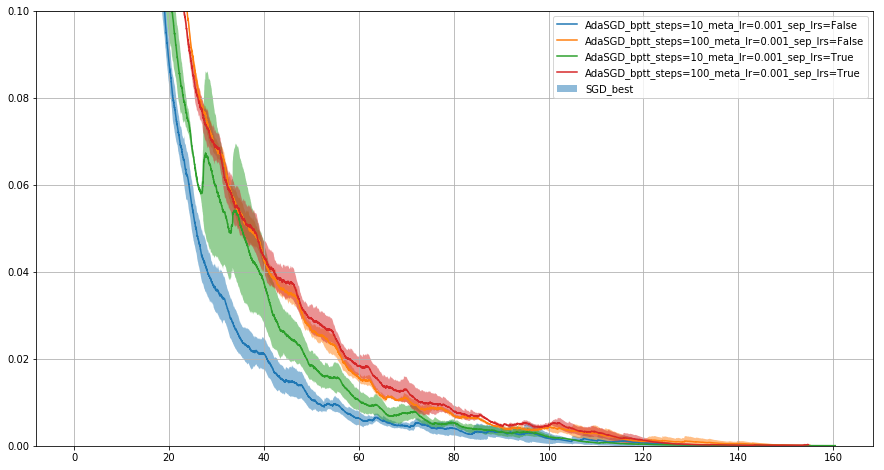

In [20]:
plt.figure(figsize=(15,8))
for opt_name in meta_opt_names:
    runs = running_average(losses[model_name][opt_name].T)
    time_runs = times[model_name][opt_name].T
    plt.plot(time_runs.mean(axis=1), runs.mean(axis=1))
    plt.fill_between(
        time_runs.mean(axis=1),
        runs.mean(axis=1) - runs.std(axis=1),
        runs.mean(axis=1) + runs.std(axis=1),
        alpha=0.5
    )
#for opt_name in ['SGD_lr=0.05']:
#    runs = running_average(losses[model_name][opt_name].T)
#    time_runs = times[model_name][opt_name].T
#    plt.plot(time_runs.mean(axis=1), runs.mean(axis=1), 'k--')
plt.grid(True)
plt.ylim(0.0, 0.1)
plt.legend(meta_opt_names + ['SGD_best'])

In [ ]:
plt.figure(figsize=(15,8))
for opt_name in opt_names:
    runs = running_average(losses[model_name][opt_name].T)
    time_runs = times[model_name][opt_name].T
    plt.plot(time_runs.mean(axis=1), runs.mean(axis=1))
    plt.fill_between(
        time_runs.mean(axis=1),
        runs.mean(axis=1) - runs.std(axis=1),
        runs.mean(axis=1) + runs.std(axis=1),
        alpha=0.5
    )
plt.grid(True)
plt.ylim(0.0, 0.1)
plt.legend(opt_names)

In [ ]:
plt.figure(figsize=(15,8))
for opt_name in meta_opt_names:
    runs = running_average(learning_rates[model_name][opt_name].T, alpha=0.99)
    plt.plot(runs.mean(axis=1))
    plt.fill_between(
        np.arange(runs.shape[0]),
        runs.mean(axis=1) - runs.std(axis=1),
        runs.mean(axis=1) + runs.std(axis=1),
        alpha=0.5
    )
plt.grid(True)
#plt.ylim(0.0, 0.1)
plt.legend(meta_opt_names)